In [38]:
import numpy as np
from qiskit import *
from qiskit import Aer
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import RYGate

# The Algorithms:

### Rotation Gate (Definition 8) 

**input:** $num$ - numerator, $den$ - denominator

**output:** rotation gate  $\boxed{\sqrt{num/den}}$

In [39]:
def ry_gate(num, den):
    return RYGate(2*np.arccos(np.sqrt(num/den)), label=str(num)+ '/'+str(den))

### Split & Cyclic Shift (SCS) - unitaries (implemented as in Theorem 10)

**input:** $n$ - vector length, $k$ - Hamming weight, circ - quantum circuit, qr - quantum register, anc - ancilla qubits, qr_offset - clarifies on which registers of qr the swap-algorithm should be applied, anc_offset - clarifies which ancilla qubits the swap-algorithm should use, $q$ - number of qubits per vector component
        
**output:** $SCS$-unitary for the given parameters

In [40]:
def SCS(n,k,circ,qr, anc, qr_offset, anc_offset, q):
    # Prepare the needed ancilla qubits
    prepare_anc(n, k, circ, anc, anc_offset)
    for i in range(k-1):
        for j in range(q):
            # Following line corresponds to line 4 in algorithm Swap in Figure 3
            circ.cswap(anc[anc_offset + i],qr[qr_offset + j], qr[qr_offset + j +2*i + 2], ctrl_state='0')
    return circ

### Algorithm PrepareAncilla in Figure 3

**input:** $n$ - vector length, $k$ - Hamming weight, circ - quantum circuit, anc - ancilla qubits, anc_offset - clarifies which ancilla qubits the swap-algorithm should use

**output:** needed ancilla qubits for $SCS_{q\cdot n,k}$

In [41]:
def prepare_anc(n, k, circ, anc, anc_offset):
    for i in range(k-1):
        if (i!=0):
            # Following line corresponds to  line 4 in algorithm PrepareAncilla in Figure 3
            circ.append(ry_gate(n-1-i,n-i).control(1, ctrl_state='0'), [anc[anc_offset + i -1], anc[anc_offset + i]])
        else:
            # case i=0: Following line corresponds to  line 2 in algorithm PrepareAncilla in Figure 3
            circ.append(ry_gate(n-1-i,n-i), [anc[anc_offset + i]])
        if (i != k-2):
            # Following line corresponds to  line 5 in algorithm PrepareAncilla in Figure 3
            circ.cx(anc[anc_offset + i], anc[anc_offset + i+1])






### Computes number of needed ancilla qubits of $U_{q\cdot n,k}$ (see proof of Theorem 12)

**input:** $n$ - vector length, $k$ - Hamming weight

**output:** number of needed ancilla qubits of $U_{q\cdot n,k}$

In [42]:
def number_anc(n,k):
    result = (n-k)*(k)
    for i in range(k):
        result += i
    return result

# An Example:

In the following we show an example, how to prepare a generalized 4-dimensional Dicke state with $q=2$. Feel free to change the init state by adjusting the parameter $\ell 1$, $\ell 2$ and $\ell 3$. 

In [43]:
n = 4
k = 4
l1 = 2
l2 = 0
l3 = 1

anc = QuantumRegister(number_anc(n,k), 'anc')
qr = QuantumRegister(2*n, 'qr')
cr = ClassicalRegister(2*n, 'cl') # Needed for the measurements
circ = QuantumCircuit(anc,qr, cr)

# Preparation of the initial state according to the given parameter l1, l2, l3
if (k< l1 + l2 +l3):
    print("You've chosen the wrong parameter! The Hamming weight of the vector is bigger than k!")
else:
    init = ''
    for i in range(n - l1 -l2 -l3): # l0
        init += '00'
    for i in range(l1):
        init += '01'
    for i in range(l2):
        init += '10'
    for i in range(l3):
        init += '11'
    circ.initialize(init, qr[:] )
    # Set anc_offset
    anc_offset=0
    for i in range(n-1):
        circ = SCS(n-i, np.minimum(k+1, n-i),circ, qr, anc, 2*i, anc_offset, 2)
        # Update anc_offset, and use "fresh" ancilla qubits in the next iteration
        anc_offset += np.minimum(k, n-1-i)
    # Measure the final state
    for i in range(2*n):
        circ.measure(qr[i],cr[i])


#### The chosen parameters lead us to the following circuit:

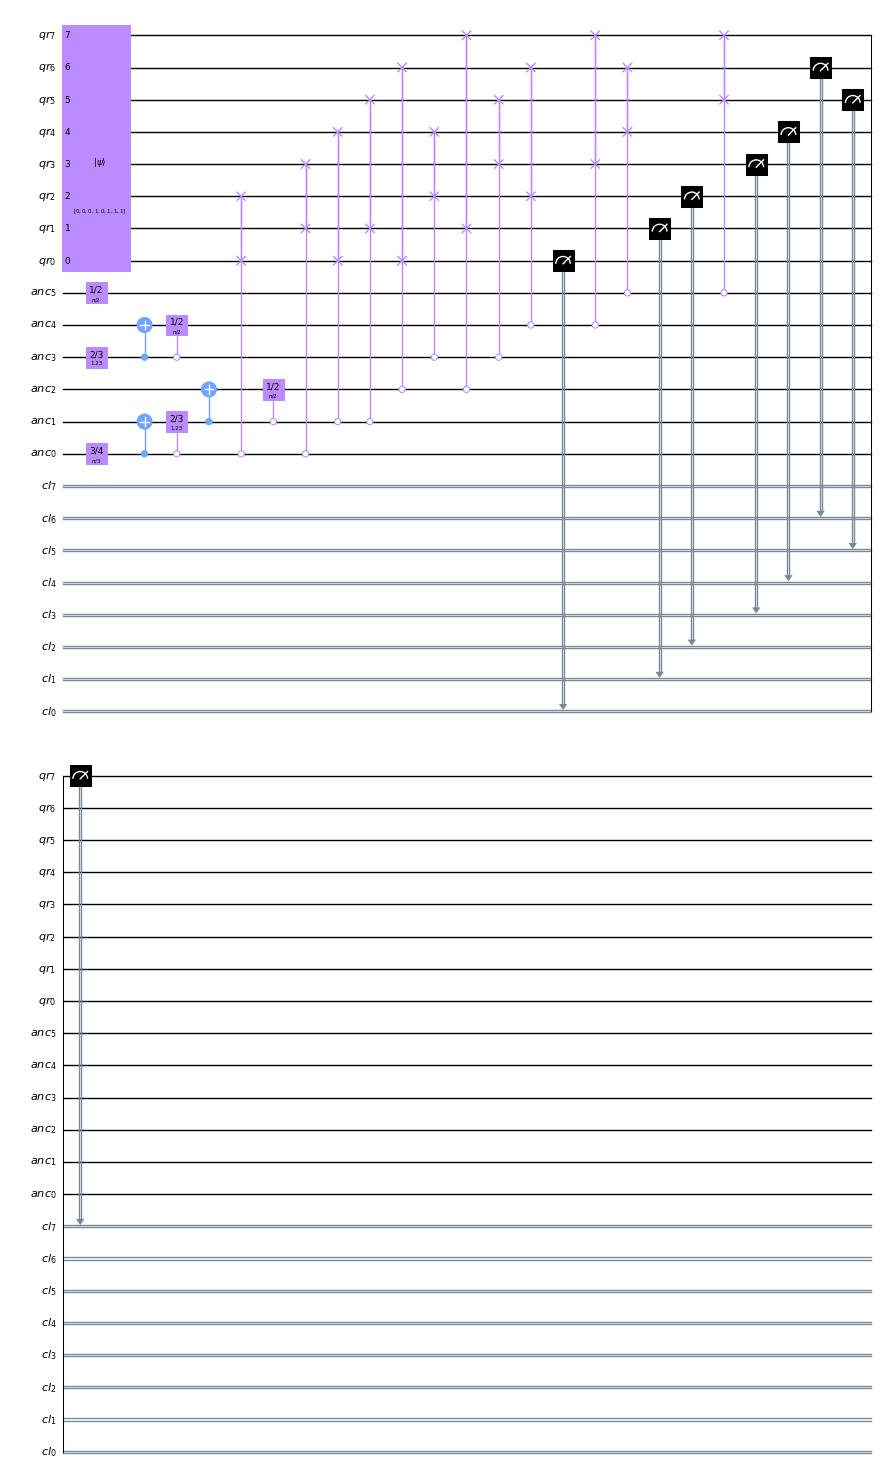

In [44]:
circ.draw('mpl', reverse_bits=True, scale=0.5)

#### A measurement of the final state "validates" the correctness of our algorithm. Note that the result of the experiment is not "perfect" since we can not run the circuit infinitely often.

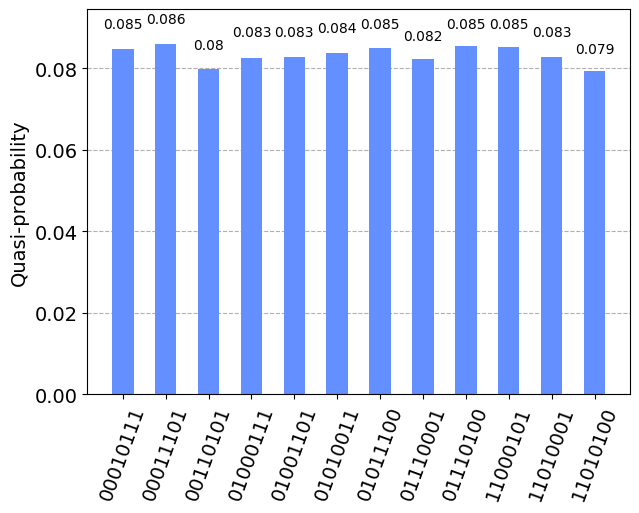

In [45]:
# shots - number of experiment repetitions:
shots = 25000

job = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result = job.result()
count = result.get_counts(circ)
#print("for initialization", init, "we get as result", count)
plot_distribution(count)